### Importing Relevant Packages

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set()

### Loading and Transforming the Data

In [2]:
raw_csv_data = pd.read_csv("Index2018.csv") 
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')



### Removing Surplus Data

In [3]:
df_comp['market_value']=df_comp.spx

del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']

In [4]:
# 80% train data, 20% test data
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

### White Noise

White noise does'nt follow any pattern (no pattern means no prediction)

Conditions:
1. Constant mean
2. Constant variance
3. No autocorrelation(how past data correlated with its version)

No autocorrelation = NO clear relationship b/w past & present values

In [5]:
# Produce normal distribution with random values
# To comparable with market value, we shaped it with mean, std.dev & size of market value 
wn = np.random.normal(loc = df.market_value.mean(), scale = df.market_value.std(), size = len(df))
df['wn'] = wn

<ipython-input-5-0411246f2eae>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wn'] = wn


In [6]:
df.describe()

,market_value,wn
count,5021.000000,5021.000000
mean,1091.651926,1088.280550
std,292.559287,293.233406
min,438.920000,-171.468560
25%,914.620000,894.335512
50%,1144.650000,1090.075841
75%,1316.280729,1285.119434
max,1570.252238,2302.257992


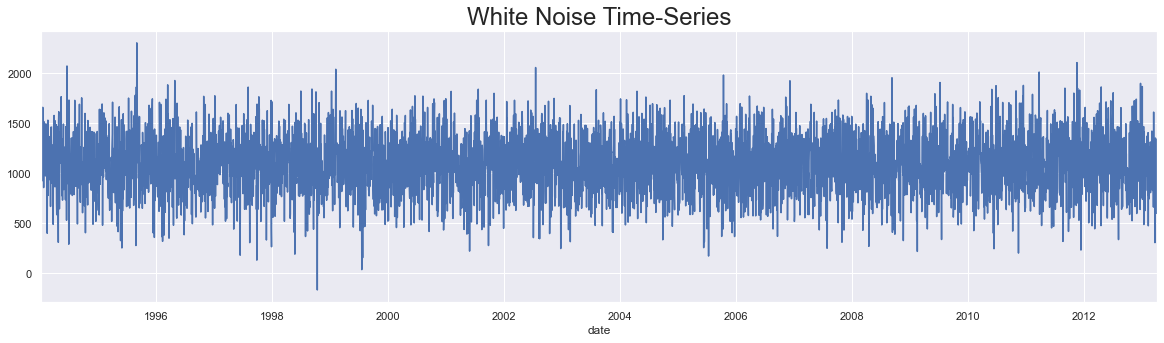

In [7]:
# Values are around the mean
df.wn.plot(figsize = (20,5))
plt.title("White Noise Time-Series", size= 24)
plt.show()

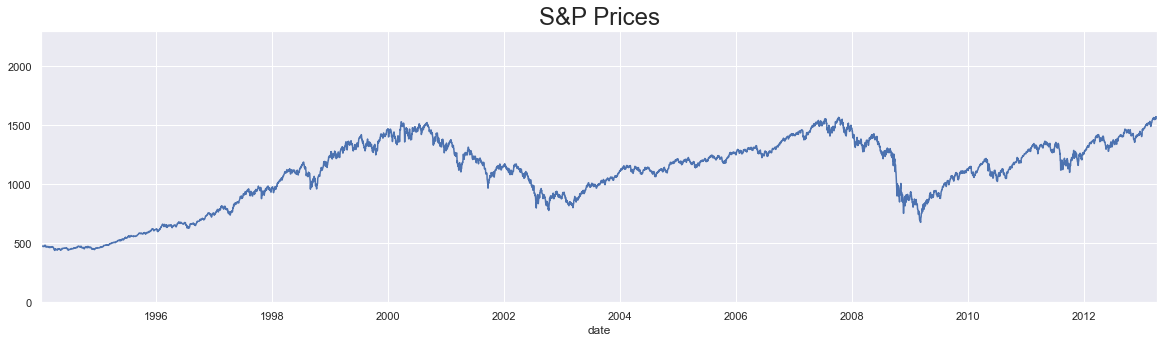

In [8]:
df.market_value.plot(figsize=(20,5))
plt.title("S&P Prices", size = 24)
plt.ylim(0,2300) # limit for y-axis
plt.show()

### Random Walk

Special time of timeseries where values tends to presist over time and the difference b/w periods are simply white noise.

In [9]:
rw = pd.read_csv("RandWalk.csv")
rw.date = pd.to_datetime(rw.date, dayfirst = True)
rw.set_index("date", inplace = True)
rw = rw.asfreq('b')

In [10]:
rw.describe()

,price
count,5021.000000
mean,1269.944293
std,444.216793
min,585.483034
25%,931.550429
50%,1156.363045
75%,1488.362029
max,2715.508720


In [11]:
df['rw'] = rw.price

<ipython-input-11-ef067d009833>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rw'] = rw.price


In [12]:
df.head()

,market_value,wn,rw
date,,,
1994-01-07,469.90,1344.041279,1122.139662
1994-01-10,475.27,1232.857172,1080.347860
1994-01-11,474.13,1244.008889,1082.095245
1994-01-12,474.17,1319.938874,1083.639265
1994-01-13,472.47,979.414328,1067.146255


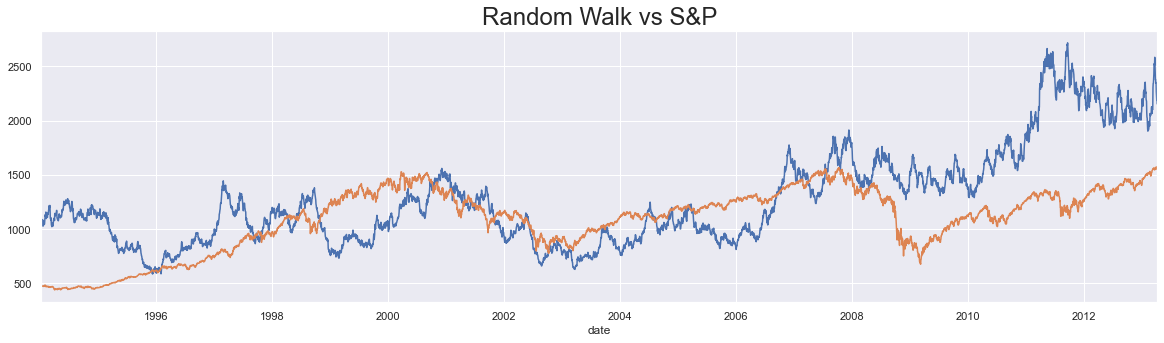

In [13]:
# Both have small variation with consecutiove timeperiod
# Bot have cyclical increases/ decreases in short period of time 
df.rw.plot(figsize = (20,5))
df.market_value.plot()
plt.title("Random Walk vs S&P", size = 24)
plt.show()

### Market Efficiency

Measures the level of difficulty in forecasting correct future values. In general if timeseries resembles with random walk price can;t be predicted with great accuracy conversly if future price can be predicted  with great accuracy then there are arbitrage opportuniites.

### Arbitrage 
Buy and sell commodities and make a safe profit, while the price adjusts

### Stationarity

Statistical stationarity: A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time. ... Such statistics are useful as descriptors of future behavior only if the series is stationary.

Taking consecutive samples of data with the same size should have identical covariances regardless of starting point of this characteristic is known as "weak-form" stationarity or "covariance" stationarity

Assumptions:
1. Constant mean
2. Constant variance
3. Consistent covariance b/w periods at an identical distance from one another.


To find that data is stationary or non-stationary:
Use Dicky-fuller test

### Dickey-Fuller Test: 
Whether data is stationary or non-stationary. If dataset is non-stationary it will useful
```
 Null Hypothesis(Ho) = Data is not stationary
 Alternative Hypothesis(H1) = Data is stationary
```

```

(-1.736984745235243,          # t-statistic
 0.4121645696770626,          # p-value
 18,                          # lags: In regression to determine t-statistic as cyclic pattern observed; Higher means data is usable 
 5002,                        # No. of observation used in analysis as it depends on lags; Higher means data is usable
 {'1%': -3.431658008603046,   # 1%: Critical value(Level of significance)
  '5%': -2.862117998412982,   # 5%: Critical value(Level of significance)
  '10%': -2.567077669247375}, # 10%: Critical value(Level of significance)
 39904.880607487445)          # autocorrelation; Lower the value easy to make prediction future
```

In [14]:
### Insights
# 1. t-statistic > 1%, 5% & 10% of significance level(critical values)  => H0 passed
#     We don't find sufficient evidence of station of parity in dataset 
# 2. p-value: 0.41  => Ho passed
#     41% chance of not rejecting null hypothses resulting can't confirm that data is stationary.
# 3. lags = 18   => Ho passed
#     Some autocorrelation going back 18 periods
# 4. No. of observation  (neglect)
# 5. Autocorrelation = lower     => Ho passed
#     lower as compared

# Conclusion: Ho = passed
#     As null hypothesis passed therfore data is non-stationary

sts.adfuller(df.market_value)

(-1.736984745235243,
 0.4121645696770626,
 18,
 5002,
 {'1%': -3.431658008603046,
  '5%': -2.862117998412982,
  '10%': -2.567077669247375},
 39904.880607487445)

In [15]:
### Insights
# 1. t-statistic < 1%, 5% & 10% of significance level(critical values)  => Ho failed
#     We find sufficient evidence of station of parity in dataset 
# 2. p-value: 0.00  => Ho failed
#     0% chance of not rejecting null hypothses resulting that data is stationary.
# 3. lags = 0   => Ho failed
#     Some autocorrelation going back 18 periods
# 4. No. of observation  (neglect)
# 5. Autocorrelation = higher     => Ho failed
#     higher as compared

### Conclusion: Ho = failed
#    As null hypothesis(Ho) failed therfore Alternative hypothesis(h1) take place; means data is stationary

sts.adfuller(df.wn)

(-51.4644642639412,
 0.0,
 1,
 5019,
 {'1%': -3.4316535759402753,
  '5%': -2.8621160400844468,
  '10%': -2.567076626752987},
 70835.19537427025)

In [16]:
### Insights
# 1. t-statistic > 1%, 5% & 10% of significance level(critical values)  => Ho passed
#     We don't find sufficient evidence of station of parity in dataset 
# 2. p-value: 0.61  => Ho passed
#     61% chance of not rejecting null hypothses resulting can't confirm that data is stationary.
# 3. lags = 24   => Ho passed
#     Some autocorrelation going back 24 periods
# 4. No. of observation  (neglect)
# 5. Autocorrelation = lower     => Ho passed
#     lower as compared

# Conclusion: Ho = passed
#     As null hypothesis passed therfore data is non-stationary

sts.adfuller(df.rw)

(-1.3286073927689708,
 0.6159849181617388,
 24,
 4996,
 {'1%': -3.4316595802782865,
  '5%': -2.8621186927706463,
  '10%': -2.567078038881065},
 46299.333497595144)

### Seasonality
seasonality suggests that certain trends will appear on a cyclical basis.
e.g; For instance temperatures rise and fall based on the times of day and months of the year.

There're 2 different seasonal patterns
```
1. Decompose the sequence where we split up the time series into three effects.
    a. Trends    -> Pattern
    b. Seasonal  -> Cyclic effect
    c. Residual  -> Error of prediction(actual - predicted)
    
    1. Naive Decomposition
        a. Additive: 
            observed = trend + seasonal + residual
        b. Multiplicative:
            observed = trend * seasonal * residual
```



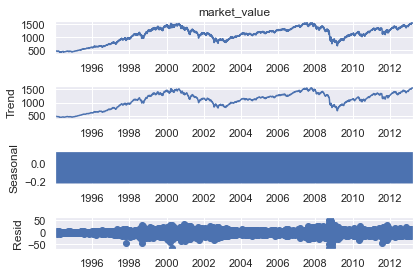

In [17]:
s_dec_additive = seasonal_decompose(df.market_value, model="additive")
s_dec_additive.plot()
plt.show()

## Insights
# 1. Trend (Neglect)
# 2. Seasonal: No concrete cyclical pattern 
#       Constantly oscillating back and forth when fig size is too small here -0.2 to 1 for every period therefore it shows square 
# 3. Residual: Shows uncertainity
#       Around 200 & late 2008-9 there is bubble created by dot com & house pricing respectively 

## Conclusion: No Seasonality 

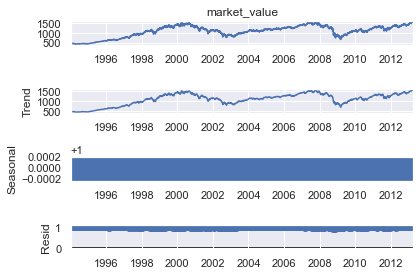

In [18]:
s_dec_multiplicative = seasonal_decompose(df.market_value, model = "multiplicative")
s_dec_multiplicative.plot()
plt.show()

## Insights
# 1. Trend (Neglect)
# 2. Seasonal: No concrete cyclical pattern 
#       Constantly oscillating back and forth when fig size is too small here -0.0002 to 0.0002 for every period therefore it shows square 
# 3. Residual: Shows uncertainity
#       Around 200 & late 2008-9 there is bubble created by dot com & house pricing respectively 

## Conclusion: No Seasonality 

### Autocorrelation
The correlation b/w a sequence and itself. More precisely measures the level of resemblance b/w a sequence from several periods ago and actual data such series is called lagged because it essentially  a delayed version of original one.

### ACF: Autocorrelation Function
```
X: lags
Y: auto correlation co efficient (-1 to 1)
Thin line: Represents autocorrelation b/w timeseries & lagged copy of itself 
        * 1st line represent autocorrelation coffecient value 1 timeperiod ago
        * 2nd line represent autocorrelation coffecient value for 2 timeperiods ago and so on.
Light blue shadow: Significane level
        * At 0 -> thin line is at 1
        * At 40 -> thin line is less than 1
        * This are expands as lag values increased
        * (i.e; The greater the distance in time, the more unlikely it is that this auto correlation persists)
        * e.g;  Todays price is much closer than yesterday's prices than the pricesa month ago.
        * Thus we make sure that autocorrelation cofficient in higher lags is suffciently greater to significanlty diff. from 0.  
```

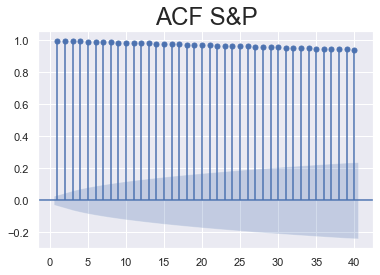

In [19]:
sgt.plot_acf(df.market_value,     # data
             lags = 40,           # First 40 lags means last 40 periods before the current one
             zero = False)        # Include current period value in graph; 
                                  #    For correlation it's unnecessary as coorelation b/w value & itself = 1
                                  #    thus ensure plot only for higher lag values
        
plt.title("ACF S&P", size = 24)
plt.show()

## Conclusion:
# All thin lines are higher than light blue shadow this suggest that autocorrelation coffecient are significant which is an indicator of time dependance in data
# Autocorrelation cofficient diminishes as lags increased suggeest that price even a month back can still serve as decent estimates 

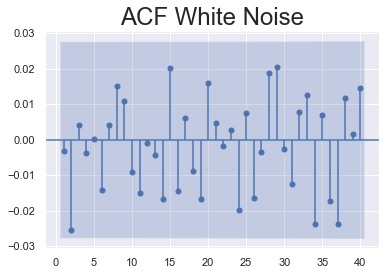

In [20]:
sgt.plot_acf(df.wn, lags = 40, zero = False)
plt.title("ACF White Noise", size = 24)
plt.show()

## Insight:
# 1. thin lines:
#     Both +ve & -ve price can close in both signs 
# 2. Light blue shadow: Significane level
#     Autocorrelation cofficient: Not significant across the entire plot for any lag

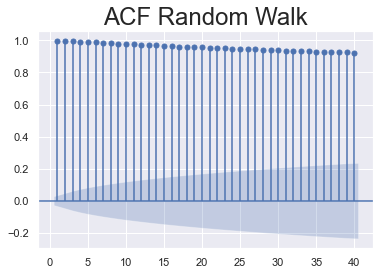

In [21]:
sgt.plot_acf(df.rw, lags = 40, zero = False)
plt.title("ACF Random Walk", size = 24)
plt.show()


## Insight:
# 1. thin lines: +ve
#     
# 2. Light blue shadow: Significane level
#     Autocorrelation cofficient: Siginificance diminishes as lags increaesed

### PACF: Partial Autocorrelation Function
```
X: lags
Y: auto correlation co efficient (-1 to 1)
Thin line: Represents autocorrelation b/w timeseries & lagged copy of itself 
        * 1st line represent autocorrelation coffecient value 1 timeperiod ago
        * 2nd line represent autocorrelation coffecient value for 2 timeperiods ago and so on.
Light blue shadow: Significane level
        * At 0 -> thin line is at 1
        * At 40 -> thin line is less than 1
        * This are expands as lag values increased
        * (i.e; The greater the distance in time, the more unlikely it is that this auto correlation persists)
        * e.g;  Todays price is much closer than yesterday's prices than the pricesa month ago.
        * Thus we make sure that autocorrelation cofficient in higher lags is suffciently greater to significanlty diff. from 0.  
```

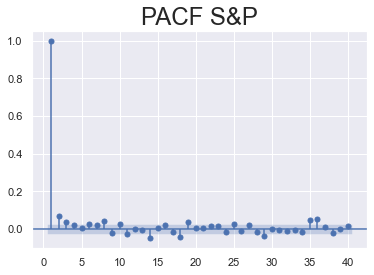

In [22]:
sgt.plot_pacf(df.market_value,    # data
             lags = 40,           # First 40 lags means last 40 periods before the current one
             method=('ols'),      # Ordinary Least Square
             zero = False)        # Include current period value in graph; 
                                  #    For correlation it's unnecessary as coorelation b/w value & itself = 1
                                  #    thus ensure plot only for higher lag values
        
plt.title("PACF S&P", size = 24)
plt.show()

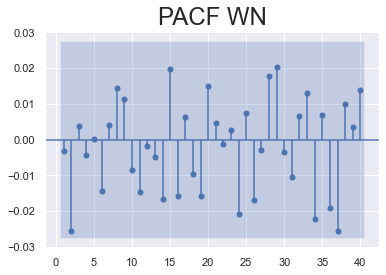

In [23]:
sgt.plot_pacf(df.wn, lags = 40, zero = False, method = ('ols'))
plt.title("PACF WN", size = 24)
plt.show()

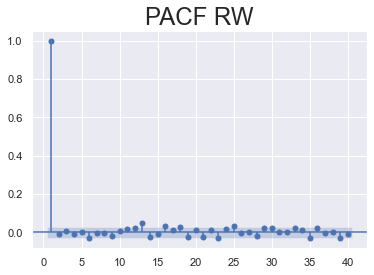

In [24]:
sgt.plot_pacf(df.rw, lags = 40, zero = False, method = ('ols'))
plt.title("PACF RW", size = 24)
plt.show()